# geopandas intersection area example

By [Ben Welsh](http://palewi.re/who-is-ben-welsh/)

In [1]:
import geopandas as gpd

In [2]:
%matplotlib inline

### Read in LA County neighborhoods for Los Angeles Times

In [3]:
hoods = gpd.read_file("la-county-neighborhoods-v6.geojson")

In [15]:
hoods.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 8 columns):
external_id     318 non-null object
geometry        318 non-null object
kind            318 non-null object
metadata        318 non-null object
name            318 non-null object
resource_uri    318 non-null object
set             318 non-null object
slug            318 non-null object
dtypes: object(8)
memory usage: 19.9+ KB


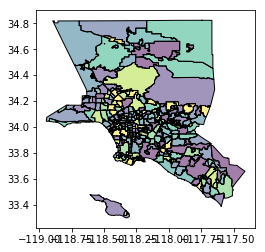

In [4]:
hoods.plot()

### Read in the state Assembly districts

In [5]:
assembly = gpd.read_file("state-assembly-districts-2011.geojson")

In [16]:
assembly.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 8 columns):
external_id     80 non-null object
geometry        80 non-null object
kind            80 non-null object
metadata        80 non-null object
name            80 non-null object
resource_uri    80 non-null object
set             80 non-null object
slug            80 non-null object
dtypes: object(8)
memory usage: 5.1+ KB


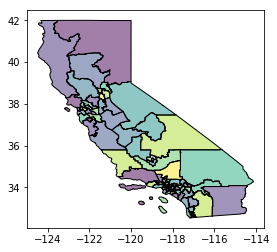

In [6]:
assembly.plot()

### Conduct a spatial join to get the intersection

Note: This will introduce a ton of duplicates as assembly districts are joined to multiple neighborhoods.

In [38]:
joined = gpd.sjoin(assembly, hoods, how="inner", op="intersects")

In [39]:
joined.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 673 entries, 32 to 73
Data columns (total 16 columns):
external_id_left      673 non-null object
geometry              673 non-null object
kind_left             673 non-null object
metadata_left         673 non-null object
name_left             673 non-null object
resource_uri_left     673 non-null object
set_left              673 non-null object
slug_left             673 non-null object
index_right           673 non-null int64
external_id_right     673 non-null object
kind_right            673 non-null object
metadata_right        673 non-null object
name_right            673 non-null object
resource_uri_right    673 non-null object
set_right             673 non-null object
slug_right            673 non-null object
dtypes: int64(1), object(15)
memory usage: 89.4+ KB


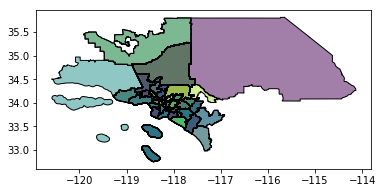

In [40]:
joined.plot()

### Get the area of all joined polygons

First using decimal degrees

In [41]:
joined.geometry.area.sum()

48.717758402443536

Then again after converting the units of measurement to feet

In [42]:
feet = joined.to_crs({'init': 'esri:102644'}).area.sum()

Finally in square miles

In [44]:
"{:,.0f}".format(feet / 27878400)

'192,174'